In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
from popsed import prior

In [2]:
name = 'NMF'
wave = np.load(f'./train_sed_{name}/{name.lower()}_seds/fsps.wavelength.npy')

if name == 'NMF_ZH':
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'gamma1_zh', 'gamma2_zh',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
else:
    spec_dir = [
        f'./train_sed_{name}/best_emu/speculator_best_recon_model_{name}.emu_{i_bin}.pkl' for i_bin in range(0, 5)]
    params_name = ['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh',
                   'fburst', 'tburst', 'logzsol',
                   'dust1', 'dust2',
                   'dust_index', 'redshift', 'logm']
speculator = SuperSpeculator(
    speculators_dir=spec_dir,
    str_wbin=['.w1000_2000',
              '.w2000_3600',
              '.w3600_5500',
              '.w5500_7410',
              '.w7410_60000'],
    wavelength=wave,
    params_name=params_name,
    device='cuda', use_speclite=True)
gama_filters = ['sdss2010-{0}'.format(b) for b in 'ugriz']
speculator._calc_transmission(gama_filters)


PHOT = 'AUTO'
noise = 'gama_snr'
noise_model_dir = f'./noise_model/gama_snr_model_mag_dr3_apmatch_{PHOT}_snr1.npy'
# noise_model_dir = f'./noise_model/gama_snr_model_mag_dr4_gkv.npy'

In [3]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag
from popsed.nde import transform_nmf_params, inverse_transform_nmf_params

In [4]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [5]:
_prior_NDE = speculator.bounds.copy()
# _prior_NDE[-2] = np.array([0., 0.65])
# _prior_NDE[-1] = np.array([7.5, 12.5])

_prior_NDE[-2] = np.array([0., 0.8])
_prior_NDE[-1] = np.array([7.5, 13.])

In [6]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

In [7]:
seed = 22
np.random.seed(seed)

_bounds = speculator.bounds.copy()
_bounds = np.zeros_like(_bounds)
_bounds = np.vstack([-np.abs(np.random.normal(size=len(_bounds)) / 10), 
                   np.abs(np.random.normal(size=len(_bounds)) / 10)]).T

_stds = np.ones(len(_bounds))

NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name=name,
                                              num_transforms=20,  # 10
                                              num_bins=60,  # how smashed it is. 10
                                              hidden_features=100,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': _stds,
                                                           },
                                              normalize=False,
                                              regularize=True, 
                                              NDE_prior=_prior_NDE,#np.vstack([_prior_NDE[:-2], _prior_NDE[-1:]])
                                             )

In [8]:
8.69 - 12

-3.3100000000000005

In [9]:
true_params = np.load(f'./reference_catalog/GAMA/gama_clean_z_mass_dr3_apmatch_{PHOT}_snr1.npy')
# true_params = np.load(f'./reference_catalog/GAMA/gama_clean_z_mass_dr4_gkv.npy')
# true_params_unt = true_params_unt[np.random.randint(0, len(true_params_unt), 10000)]
# true_params = np.hstack([prior.FlatDirichletPrior(4).transform(true_params_unt[:, :3]),
#                       true_params_unt[:, 3:-1], 
#                       true_params_unt[:, -1:]])

In [24]:
folder = 'lr3e-4_ann8_40e_dr3ap_auto_snr1_1'
for epoch in range(0, 40):
    samples = torch.Tensor(np.load(f'./NDE/GAMA/anneal/real/lr3e-4_ann8_40e/nsf_1_sample_{epoch + 1}.npy')).to('cuda')
    _samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
    _samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                          _samples_unt[:, 3:-1], 
                          _samples_unt[:, -1:]])
    
    _labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
    _labels = [key.replace('_', '\_') for key in _labels]

    figure = corner.corner(true_params, 
                      labels=['z', 'log m', 'logzsol'], bins=30,
                      color='gray', # quantiles=[0.16, 0.5, 0.84], 
                           range=[[0, 0.8], [8, 13], [-2, 1]], 
                      smooth=0.5, fill_cont1ours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                            hist_kwargs={'density': True}, plot_datapoints=True)


    nf_plot = corner.corner(np.hstack([_samples[:, -2:-1], _samples[:, -1:] - 0.3, _samples[:, 6:7]]),
                            fig=figure,
                      labels=['z', 'log m', 'logzsol'], bins=30,
                      color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                      smooth=0.5, fill_contours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                            hist_kwargs={'density': True}, plot_datapoints=False)
    
    if not os.path.isdir(f'./NDE/GAMA/NMF/movie/{folder}'):
        os.makedirs(f'./NDE/GAMA/NMF/movie/{folder}')
    plt.savefig(f'./NDE/GAMA/NMF/movie/{folder}/image{epoch:02d}.png', bbox_inches='tight', dpi=50)
    plt.close()

In [26]:
with open('./NDE/GAMA/anneal/real/lr3e-4_ann12_40e/nde_theta_last_model_nsf_1.pkl', 'rb') as f:
    NDE_theta = pickle.load(f)

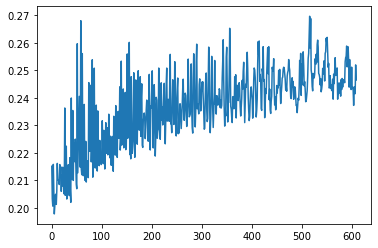

In [27]:
plt.plot(NDE_theta.vali_loss_history[500:])

In [ ]:
NDE_theta.save_model(
        os.path.join(NDE_theta.output_dir,
                     f'nde_theta_last_model_{NDE_theta.method}_{NDE_theta.seed}.pkl')
    )

In [20]:
folder = 'lr3e-4_ann7p5_10t'
for epoch in range(30):
    samples = torch.Tensor(np.load(f'./NDE/GAMA/anneal/mock/{folder}/nsf_0_sample_{epoch + 1}.npy')).to('cuda')
    _samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
    _samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                          _samples_unt[:, 3:-1], 
                          _samples_unt[:, -1:]])
    
    _labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
    _labels = [key.replace('_', '\_') for key in _labels]

    figure = corner.corner(true_params, 
                      labels=_labels, bins=30,
                      color='gray', # quantiles=[0.16, 0.5, 0.84], 
                      smooth=0.5, fill_cont1ours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                            hist_kwargs={'density': True}, plot_datapoints=True)


    nf_plot = corner.corner(_samples, 
                            fig=figure,
                      labels=_labels, bins=30,
                      color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                      smooth=0.5, fill_contours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                            hist_kwargs={'density': True}, plot_datapoints=False)
    
    if not os.path.isdir(f'./NDE/GAMA/NMF/movie/{folder}'):
        os.makedirs(f'./NDE/GAMA/NMF/movie/{folder}')
    plt.savefig(f'./NDE/GAMA/NMF/movie/{folder}/image{epoch:02d}.png', bbox_inches='tight', dpi=50)
    plt.close()

rsync -azvr --progress jiaxuanl@della.princeton.edu:/scratch/gpfs/jiaxuanl/Data/popsed/NDE/GAMA/NMF/movie ./

In [9]:
# real gama data
folder = 'lr2e-4_ann7p5_30'
for epoch in range(30):
    samples = torch.Tensor(np.load(f'./NDE/GAMA/anneal/real/{folder}/nsf_0_sample_{epoch + 1}.npy')).to('cuda')
    _samples_unt = inverse_transform_nmf_params(samples, NDE_theta.NDE_prior).detach().cpu().numpy()
    _samples = np.hstack([prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]),
                          _samples_unt[:, 3:-1], 
                          _samples_unt[:, -1:]])
    
    _labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
    _labels = [key.replace('_', '\_') for key in _labels]

    figure = corner.corner(true_params, 
                      labels=_labels, bins=30,
                      color='gray', # quantiles=[0.16, 0.5, 0.84], 
                      smooth=0.5, fill_contours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                            hist_kwargs={'density': True}, plot_datapoints=True)


    nf_plot = corner.corner(_samples, 
                            fig=figure,
                      labels=_labels, bins=30,
                      color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                      smooth=0.5, fill_contours=True,
                      show_titles=True, title_kwargs={"fontsize": 12}, 
                            hist_kwargs={'density': True}, plot_datapoints=False)

    if not os.path.isdir(f'./NDE/GAMA/NMF/movie/{folder}_real'):
        os.makedirs(f'./NDE/GAMA/NMF/movie/{folder}_real')
    plt.savefig(f'./NDE/GAMA/NMF/movie/{folder}_real/image{epoch:02d}.png', bbox_inches='tight', dpi=50)
    plt.close()

In [31]:
0.25 * 30

7.5

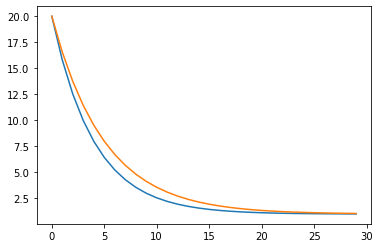

In [37]:
anneal_coeff = 7.5
max_epochs = 30
plt.plot([1 + 19 * np.exp(- anneal_coeff / max_epochs * i) for i in range(max_epochs)])

anneal_coeff = 6.
plt.plot([1 + 19 * np.exp(- anneal_coeff / max_epochs * i) for i in range(max_epochs)])

In [39]:
"_".join(['a', 'b'])

'a_b'

In [ ]:
np.load('./NDE/GAMA/mo')